# Phylogenetics of Whole Genome Sequences Enterovirus D68 samples from NCBI and PHO

In [1]:
# import packages
import os
import scrubbing
import pandas as pd
from datetime_funcs import str_date_to_year_fraction

In [2]:
# load cleaned metadata
metadata = pd.read_csv('data/cleaned_EvD68_metadata.csv')
analysis_dir = 'WGS_analysis'
cleaned_fasta_file = 'data/cleaned_NCBI_EvD68.fasta'

# Applying Filters to Select WGS seuences

* Remove those sequences less 5000

In [3]:
filtered_fasta = analysis_dir +'/WGS_ref_and_NCBI_EvD68.fasta'
to_remove = metadata.Accession[metadata.Length<5000].to_list()
scrubbing.remove_if_accession_in_list(cleaned_fasta_file, filtered_fasta, to_remove)

* Remove if sequence id title has a reference to being part of the genome.


In [4]:
parts_of_genome = ['VP' + str(num) for num in range(1,5)] + ['capsid', 'UTR', 'p2A', 'p2B', 'p2C', '3A', '3B', '3C', '3D']
to_remove += scrubbing.remove_if_any_substrings_in_tag(filtered_fasta, filtered_fasta, parts_of_genome)

* Remove if N is greater than 0.05 in proportion of sequence.

In [5]:
to_remove += scrubbing.remove_if_character_prop_over(filtered_fasta, filtered_fasta, prop=0.05, character='N')

In [6]:
# update metadata
metadata = metadata[~metadata.Accession.isin(to_remove)]

In [7]:
# Save WGS metatdata
metadata.to_csv(analysis_dir+'/WGS_NCBI_metadata.csv', index=False)

In [8]:
lengths = metadata.Length.value_counts(dropna=False).rename_axis('unique_values').reset_index(name='counts')

In [9]:
metadata.Length.describe()

count    1047.000000
mean     7186.093601
std       351.336972
min      5074.000000
25%      7250.500000
50%      7292.000000
75%      7329.000000
max      7430.000000
Name: Length, dtype: float64

# Include PHO Sequences

* Add PHO sequence limited metadata to our metadata.

In [10]:
pho_metadata = pd.read_csv('data/PHO_metadata.csv')
metadata = pd.concat([metadata,pho_metadata])

In [11]:
# Create new column called date and name. These columns are for use with 'augur refine' later.
metadata['date'] =  [str_date_to_year_fraction(date_string) for date_string in metadata.Collection_Date.to_list()]
metadata.Accession = metadata.Accession.str.strip(' ')
metadata['name'] =  metadata.Accession
metadata.loc[metadata.Geo_Location=='Canada: On', 'Country'] = 'Canada'
metadata.to_csv(analysis_dir + '/WGS_NCBI_and_PHO_metadata.csv', index=False)

 * Merge PHO sequences onto bottom of our filtered_ref_and_NCBI_EvD68.fasta to produce a WGS file for use in alignment

In [12]:
%%bash
cat WGS_analysis/WGS_ref_and_NCBI_EvD68.fasta data/PHO_WGS_EvD68.fasta > WGS_analysis/WGS_to_align.fasta

* Create a tsv version of metadata for use in TempEst and beagle.

In [13]:
metadata_TempEst = metadata[['Accession','date']]
metadata_TempEst.to_csv(analysis_dir + '/WGS_NCBI_and_PHO_metadata.tsv', index=False, sep='\t')

# Running mafft alignment

In [14]:
%%bash
augur align --nthreads auto --sequences WGS_analysis/WGS_to_align.fasta --reference-name AY426531.1 --output WGS_analysis/WGS_aligned.fasta


using mafft to align via:
	mafft --reorder --anysymbol --nomemsave --adjustdirection --thread 8 WGS_analysis/WGS_aligned.fasta.to_align.fasta 1> WGS_analysis/WGS_aligned.fasta 2> WGS_analysis/WGS_aligned.fasta.log 

	Katoh et al, Nucleic Acid Research, vol 30, issue 14
	https://doi.org/10.1093%2Fnar%2Fgkf436



/NetDrive/Labs/Duvvuri/Martins_VM_Programs/anaconda3/envs/temp_EvD68/lib/python3.11/site-packages/Bio/Seq.py:2096: BiopythonDeprecationWarning: myseq.ungap(gap) is deprecated; please use myseq.replace(gap, "") instead.
  warnings.warn(


29bp insertion at ref position 0
	TGTTTGCGAACGAGTTTAGGATT: MK989726.1
	AAAACAACTTATCCGTTATCCGT: MK989725.1
	T: KT285484.1, MG739635.1
1bp insertion at ref position 8
	G: KU982561.1
1bp insertion at ref position 10
	T: OP321143.1, OP321151.1
1bp insertion at ref position 17
	G: KU982558.1, KU982559.1, KU982560.1
1bp insertion at ref position 26
	C: KU844179.1, MN240507.1, MN240508.1, OQ791518.1, MN240518.1, MN240506.1, MN240519.1, KX255360.1, KX255374.1, KX255355.1, MN240505.1, MN240495.1, KX255409.1, KX261804.1, KX261824.1, JX070222.1, KX255358.1, KX255369.1, KX255359.1, KX255396.1, KX255392.1, KX255380.1, KX255404.1, KX255381.1, KX255386.1, KX255361.1, KT347280.1, KX255376.1, LC068708.1, LC068710.1, LC068709.1, LC629437.1, KX789259.2, MN240516.1, JX101846.1, MN240491.1, MN240503.1, KX255363.1, MN240493.1, MN240492.1, MN240512.1, MN240515.1, KM892500.1, MN240494.1, KY348862.1, MN240499.1, MN240510.1, MN240501.1, LC629442.1, LC629444.1, LC629443.1, MK989723.1, MK989726.1, MK989724.1, MK

## Buiding tree

In [15]:
%%bash
augur tree --substitution-model auto --nthreads auto --alignment WGS_analysis/WGS_aligned.fasta --output WGS_analysis/WGS_tree.nwk

Building a tree via:
	iqtree -nt 8 -s WGS_analysis/WGS_aligned-delim.fasta -ninit 2 -n 2 -me 0.05 > WGS_analysis/WGS_aligned-delim.iqtree.log
	Nguyen et al: IQ-TREE: A fast and effective stochastic algorithm for estimating maximum likelihood phylogenies.
	Mol. Biol. Evol., 32:268-274. https://doi.org/10.1093/molbev/msu300

Conducting a model test... see 'WGS_analysis/WGS_aligned-delim.iqtree.log' for the result. You can specify this with --substitution-model in future runs.

Building original tree took 4988.384632825851 seconds


# Refining Tree

* Refining Tree with regards to date. 

In [16]:
%%bash
augur refine --alignment WGS_analysis/WGS_aligned.fasta\
    --tree WGS_analysis/WGS_tree.nwk\
    --metadata WGS_analysis/WGS_NCBI_and_PHO_metadata.csv\
    --timetree --divergence-units mutations\
    --output-tree WGS_tree.time.nwkWGS_analysis/\
    --output-node-data WGS_analysis/WGS_refine.node.json --keep-root

augur refine is using TreeTime version 0.8.6

4.06	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.

27.26	###TreeTime.run: INITIAL ROUND

65.54	###TreeTime.run: ITERATION 1 out of 2 iterations

145.83	###TreeTime.run: ITERATION 2 out of 2 iterations

Inferred a time resolved phylogeny using TreeTime:
	Sagulenko et al. TreeTime: Maximum-likelihood phylodynamic analysis
	Virus Evolution, vol 4, https://academic.oup.com/ve/article/4/1/vex042/4794731

updated tree written to WGS_analysis/WGS_tree.time.nwk
node attributes written to WGS_analysis/WGS_refine.node.json


* Infer ancestor using treetime.

In [14]:
%%bash
augur ancestral --tree WGS_analysis/WGS_tree.time.nwk\
    --alignment WGS_analysis/WGS_aligned.fasta\
    --output-node-data WGS_analysis/WGS_nucleotide_subs.node.json

augur ancestral is using TreeTime version 0.8.6

Inferred ancestral sequence states using TreeTime:
	Sagulenko et al. TreeTime: Maximum-likelihood phylodynamic analysis
	Virus Evolution, vol 4, https://academic.oup.com/ve/article/4/1/vex042/4794731

ancestral mutations written to WGS_analysis/WGS_nucleotide_subs.node.json


## Translate genome.

#### Reference sequence is required in genebank format for this.
* Navigate to https://www.ncbi.nlm.nih.gov/genbank/
* Enter reference accession number AY426531 in search.

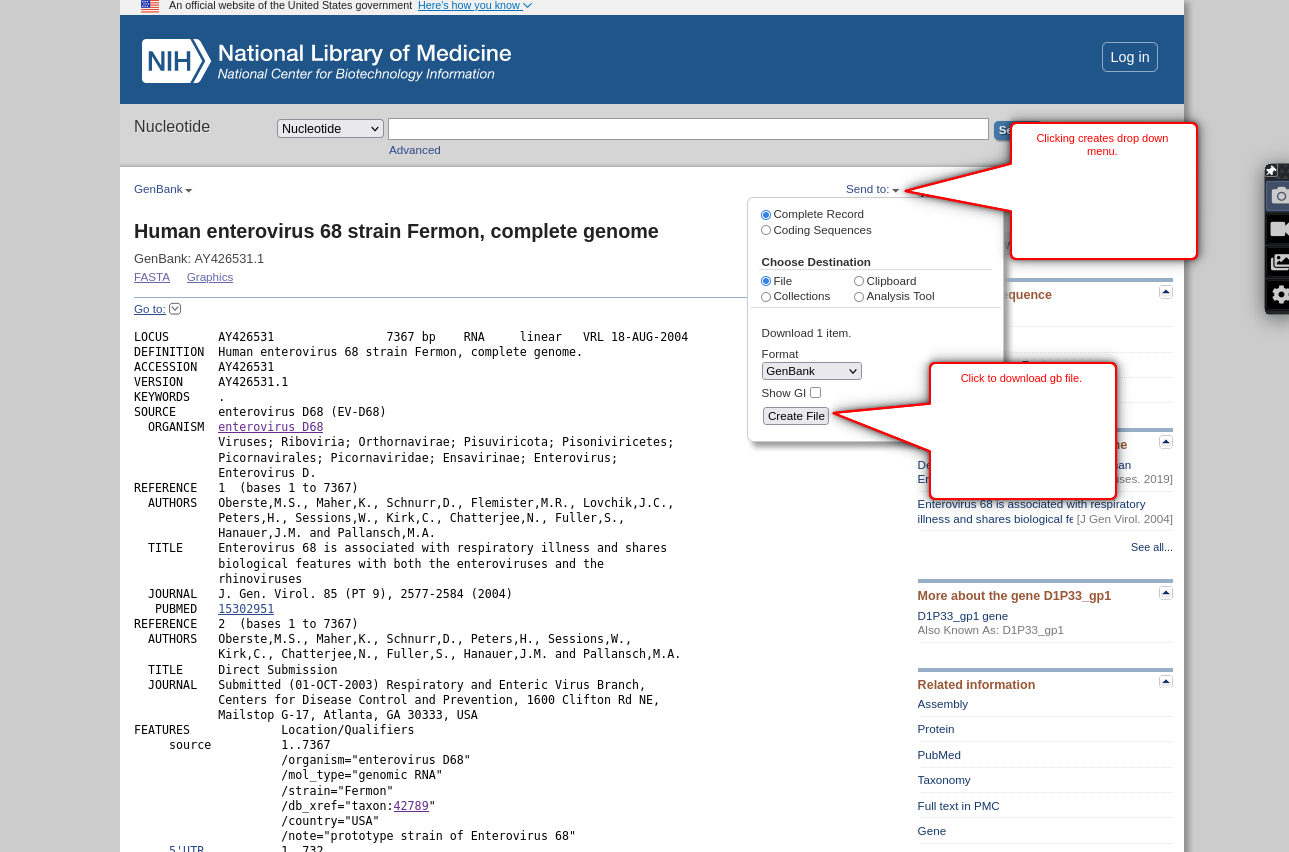

* Relabel sequence.gb to ref_EvD68.gb and move from donwloads to local data folder.
* Open ref_EvD68.gb text editor and edit as set out in https://docs.nextstrain.org/projects/augur/en/10.0.4/tutorials/zika_tutorial.html "Identify Amino-Acid Mutations" section:
    * For all mat_peptide sections copy line with "/product=" in to below its occurance. In copied line replace "product" with "gene" and remove the sub-string " protein".
    * replace "mat_peptide     " with "CDS             "

In [15]:
%%bash
augur translate --tree WGS_analysis/WGS_tree.time.nwk\
    --ancestral-sequences WGS_analysis/WGS_nucleotide_subs.node.json\
    --reference-sequence data/ref_EvD68.gb\
    --alignment-output WGS_analysis/aa_alignment_%GENE.fasta\
    --output-node-data WGS_analysis/aa_mutations.json

Read in 12 features from reference sequence file
amino acid mutations written to WGS_analysis/aa_mutations.json


## Add information to metadata regarding Maryland 2022 outbreak and Canada: On 2022 outbreak

In [85]:
metadata = pd.read_csv('WGS_analysis/26052023_WGS_NCBI_and_PHO_metadata.csv')
metadata['Outbreak'] = None
metadata.Outbreak[metadata.Accession.str.startswith('PHL')] = 'Ontario 7-10/2022'
JHL_2022_accessions = ['OP'+str(num) for num in range(572035, 572095+1)]
JHL_2022_accessions += ['OP'+str(num) for num in range(321139, 321154+1)]
metadata.Outbreak[metadata.Accession_without_decimal.isin(JHL_2022_accessions)] = 'Maryland 7-9/2022'


/tmp/ipykernel_334730/1741976426.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata.Outbreak[metadata.Accession.str.startswith('PHL')] = 'Ontario 7-10/2022'
/tmp/ipykernel_334730/1741976426.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata.Outbreak[metadata.Accession_without_decimal.isin(JHL_2022_accessions)] = 'Maryland 7-9/2022'


In [86]:
metadata['Outbreak/Country'] = metadata.Country
metadata['Outbreak/Country'][metadata.Accession.str.startswith('PHL')] = 'Ontario 7-10/2022'
metadata['Outbreak/Country'][metadata.Accession_without_decimal.isin(JHL_2022_accessions)] = 'Maryland 7-9/2022'
values_to_keep = ['Ontario 7-10/2022','Maryland 7-9/2022','France','Sweden','Netherlands','USA','Australia']
metadata['Outbreak/Country'][~metadata['Outbreak/Country'].isin(values_to_keep)] =None


/tmp/ipykernel_334730/4116672481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['Outbreak/Country'][metadata.Accession.str.startswith('PHL')] = 'Ontario 7-10/2022'
/tmp/ipykernel_334730/4116672481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['Outbreak/Country'][metadata.Accession_without_decimal.isin(JHL_2022_accessions)] = 'Maryland 7-9/2022'
/tmp/ipykernel_334730/4116672481.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [87]:
metadata.drop(columns='name',inplace=True)
metadata['strain'] = metadata.Accession
metadata.to_csv('WGS_analysis/WGS_NCBI_and_PHO_metadata.csv', index=False)

In [88]:
outbreak_colours = pd.DataFrame([['Outbreak','Ontario 7-10/2022','#d95f0e'],['Outbreak','Maryland 7-9/2022','#fec44f'],['Outbreak/Country','Ontario 7-10/2022','#d95f0e'],['Outbreak/Country','Maryland 7-9/2022','#fec44f']])
outbreak_colours.to_csv('WGS_analysis/outbreak_colours.txt',header=False, index=False, sep='\t')

## Making export json file for Auspice

In [90]:
%%bash
augur export v2 --tree WGS_analysis/WGS_tree.time.nwk\
    --node-data WGS_analysis/WGS_refine.node.json WGS_analysis/WGS_nucleotide_subs.node.json WGS_analysis/aa_mutations.json\
    --metadata WGS_analysis/WGS_NCBI_and_PHO_metadata.csv\
    --output WGS_analysis/analysis-package.json

Validating schema of 'WGS_analysis/aa_mutations.json'...


Validating produced JSON
Validating schema of 'WGS_analysis/analysis-package.json'...
Validating that the JSON is internally consistent...
Validation of 'WGS_analysis/analysis-package.json' succeeded.



# Run interactive visualisations with auspice

The command below should be performed from terminal after moving to this working directory.

`auspice view --datasetDir WGS_analysis`

* From auspice local host select analysis-package.json.
* Drag and drop WGS_analysis/WGS_NCBI_and_PHO_metadata.csv onto auspice local host.

## Adding missing clade labels

* Use the current metadata to select a branch for a clade. Then download the metadata, relabeling for the apropriate clade in file name and move to local WGS_analysis directory.

In [ ]:
clades = ['A1','A2','B', 'B1','B2','B3','C']
new_metadata = []
for clade in clades:
    clade_metadata = pd.read_table('WGS_analysis/' + clade + '_metadata.tsv', sep='\t')
    clade_metadata.clade[clade_metadata.clade.isna()] = clade
    new_metadata.append(clade_metadata)

new_metadata = pd.concat(new_metadata)
new_metadata.rename(columns={'strain': 'Accession'}, inplace=True)


In [ ]:
metadata_no_clade_info = metadata[~metadata.Accession.isin(new_metadata.Accession)]
new_metadata = pd.concat([new_metadata,metadata_no_clade_info])


In [ ]:
more_outbreak_info = {'Sweden 9/2022': ['OQ160430.1', 'OQ160433.1', 'OQ160431.1'],
                      'France 8/2022': ['OP389245.1', 'OP389246.1']}
for outbreak, accession_list in more_outbreak_info.items():
    new_metadata.Outbreak[new_metadata.Accession.isin(accession_list)] = outbreak


/tmp/ipykernel_618116/1735458598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_metadata.Outbreak[new_metadata.Accession.isin(accession_list)] = outbreak
/tmp/ipykernel_618116/1735458598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_metadata.Outbreak[new_metadata.Accession.isin(accession_list)] = outbreak


In [ ]:
new_metadata.to_csv('WGS_analysis/WGS_metadata_updated.csv', index=False)

In [ ]:
new_metadata.Outbreak.value_counts(dropna=False)

NaN                 952
Canada 7-10/2022     87
USA 7-9/2022         74
None                 16
Sweden 9/2022         3
France 8/2022         2
Name: Outbreak, dtype: int64